In [1]:
# %% Library & Initialize Dataset and Backtesting Platform
from library.functions import *

dataset = {}
#dataset['0005.HK'] = 'EQ'  # Close, Volume
#dataset['0700.HK'] = 'EQ'  # Close, Volume
#dataset['HSI'] = 'EQ'  # Close, Volume
#dataset['PUT'] = 'Custom'  # requires functions
#dataset['CALL'] = 'Custom'  # requires functions
dataset['VHSI'] = 'Vol'  # Close
#dataset['VIX'] = 'Vol'  # Close
dataset['USDHKD'] = 'FX'  # Bid, Ask
#dataset['XAUHKD'] = 'FX'  # Bid, Ask
#dataset['HKDTRY'] = 'FX'  # Bid, Ask
#dataset['USDTRY'] = 'FX'  # Bid, Ask
#dataset['XRPUSD'] = 'FX'  # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset VHSI is loaded
Dataset USDHKD is loaded
Dataset Range: from 2018-08-07 09:31:00 to 2018-12-07 16:01:00


In [2]:
# %% Backtest Params
start = platform.validstart  # initialize start date
end = platform.validend  # initialize start date
start = datetime.datetime(2018, 9, 1, 0, 0, 0)  # initialize start date
end = datetime.datetime(2018, 12, 1, 0, 0, 0)  # initialize start date
mask = (platform.quote['USDHKD'].index > start) & (platform.quote['USDHKD'].index <= end)
backtestperiod = platform.quote['USDHKD'].loc[mask]
platform.initportfolio(10000000, 100)  # reset initial cash + default handling fee

In [3]:
# %% Backtesting
prev = None  # for accessing last minute quotation
# start looping every 1 minute
print('Start Backtesting...')
for time, reference in backtestperiod.iterrows():
    # Examples:
    if not prev:  # skip first loop to record the time
        # HSI derivatives
        prev = time
        continue

    # Check if EQ market is opened
    if platform.is_eqmktopen(time):

        # Trade conditions
        if (    # One trade per day at 16:10
                time.time() == datetime.time(16, 10, 0)  
        ):
            # Close Existing Position
            # High Volatility
            if platform.quote['VHSI'].loc[time].Close > 16:
                if platform.has_pos('VHSI') is not 'SHORT':                    
                    if platform.has_pos('VHSI'):
                        platform.trade(time, 'VHSI', 'CLOSE')  
                    platform.trade(time, 'VHSI', 'SHORT', 5000)
            # Low Volatility
            elif platform.quote['VHSI'].loc[time].Close < 16:  
                if platform.has_pos('VHSI') is not 'LONG':                      
                    if platform.has_pos('VHSI'):
                        platform.trade(time, 'VHSI', 'CLOSE')  
                    platform.trade(time, 'VHSI', 'LONG', 5000)
                
    # EQ is not in trading hours
    else:
        pass                                             

    prev = time  # Save this time for next loop

    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        platform.updatepos(time)

Start Backtesting...
2018-09-03 16:10:00 Avl.Cash: 9901750.0 VHSI SHORT 5000 @ 19.63


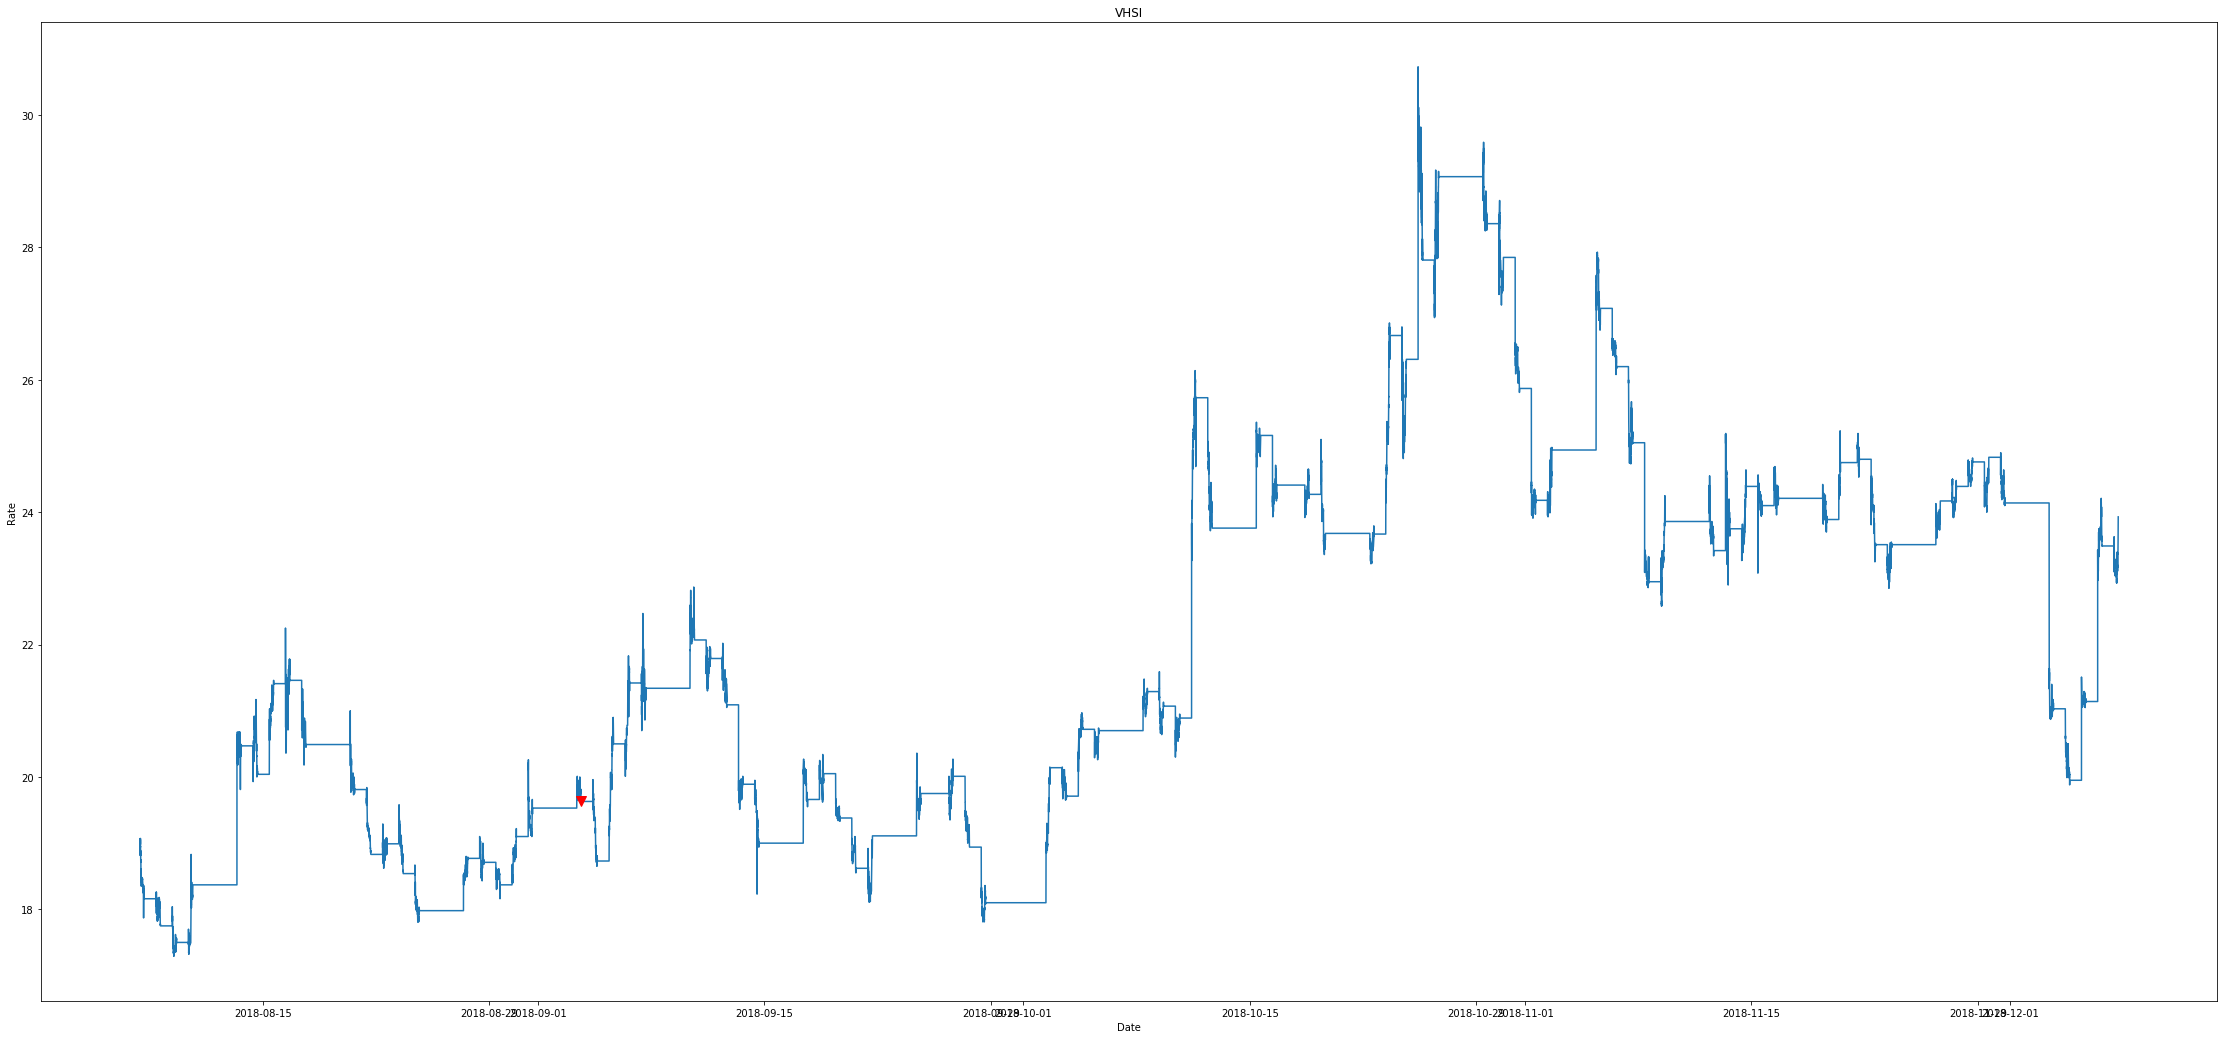

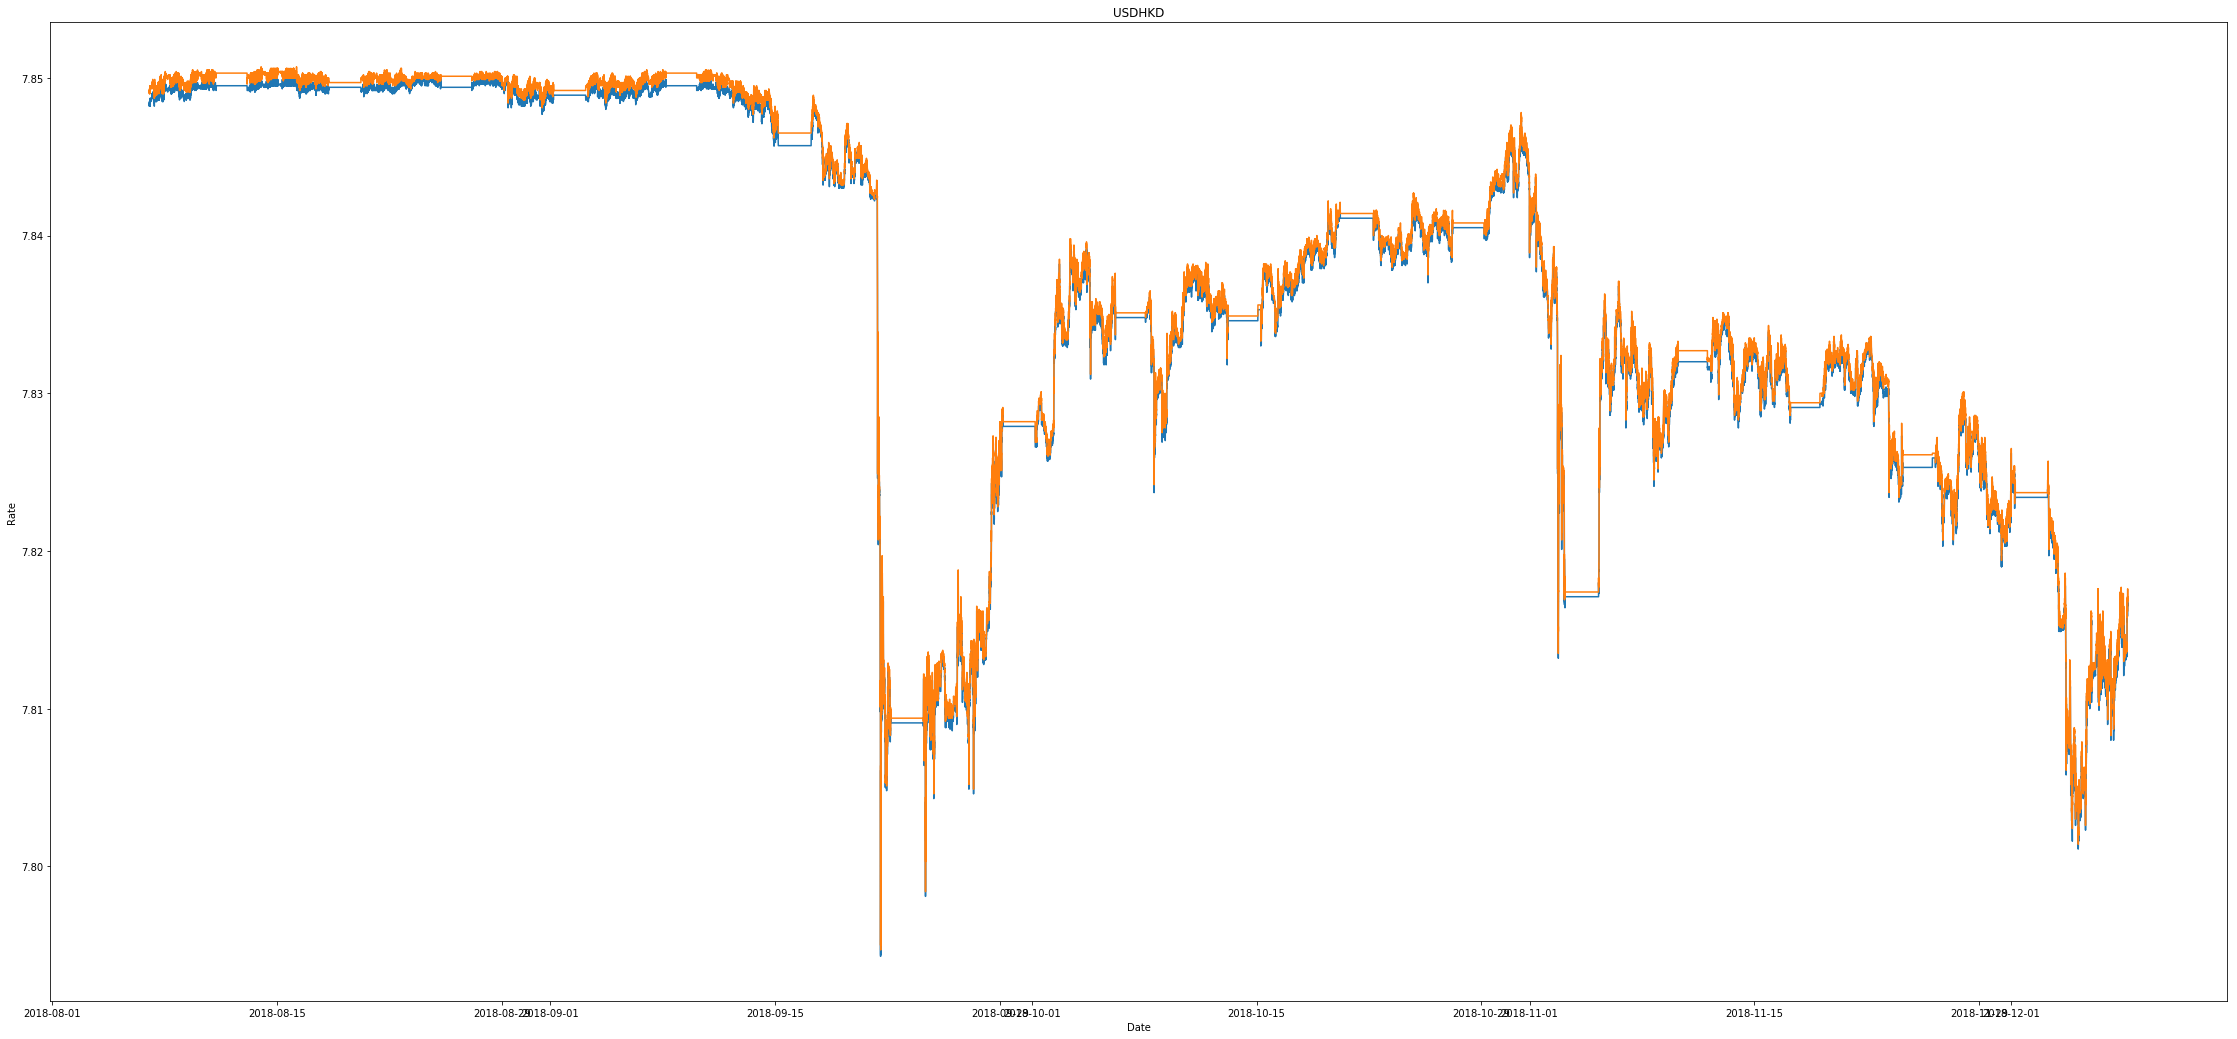

Activities:
  Product Position  Open Rate Close Rate      P&L
0    VHSI    SHORT       19.6       None -22750.0
Summary:
Initial Cash: 10000000 Final Cash: 9901750.0
Unrealized P&L: -22750.0 Realized P&L: 0
Overall P&L: -22750.0 P&L%: -0.0


In [4]:
from pylab import *
rcParams['figure.figsize'] = (39, 18)
# %% Export Portfolio
tradelog = None
portfolio, tradelog = platform.exporttrades()
for i in range(len(tradelog)):
    tradelog.loc[i, 'P&L'] = tradelog.loc[i, 'Unrealized P&L'] + tradelog.loc[i, 'Realized P&L']
print('Activities:')
print(tradelog[['Product', 'Position', 'Open Rate', 'Close Rate', 'P&L']])
print('Summary:')
print('Initial Cash:', round(portfolio['initial']), 'Final Cash:', round(portfolio['cash']))
print('Unrealized P&L:', round(portfolio['Unrealized P&L']), 'Realized P&L:', round(portfolio['Realized P&L']))
print('Overall P&L:', round(portfolio['P&L']), 'P&L%:', round(portfolio['P&L%']))

In [5]:
# %% insert
tradelog.to_excel('vhsi.xlsx')